In [1]:
import os
import math
import random
import numpy as np
import random
import torch
import models
from models import DeepLab
import matplotlib.pyplot as plt
import draw, utils

In [2]:
datafloder_name = "F3data"
datanpy_name = 'F3data.npy'
model_name="smallscale"
chekpoint_name = 'checkpoint-best.pth'

In [ ]:
num_sample = 461
m1,m2 = 300,400
root_path = os.path.abspath(".")
dataset_name = 'Field_data'
dataset_path = os.path.join(root_path, "datasets", dataset_name)
train_dataset_path = os.path.join(dataset_path, datafloder_name)
sample_name_list = []
for i in range(num_sample):
    train_sample_file = f'{i}'
    sample_name_list.append(train_sample_file)
# random.shuffle(sample_name_list)
samples_rawdata = []
for sample_name in sample_name_list[:num_sample]:
    samples_rawdata.append(sample_name)
np.save(os.path.join(dataset_path,datanpy_name), samples_rawdata)
# print(samples_rawdata)

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES']= '5'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    num_GPU = torch.cuda.device_count()
    print(f"GPU number: {num_GPU}")
print(f"operation platform: {device}")
    
root_path = os.path.abspath('.')

In [ ]:
dataset_name = 'Field_data'
dataset_path = os.path.join(root_path, "datasets", dataset_name)
                            
samples_rawdata = np.load(os.path.join(dataset_path,datanpy_name), allow_pickle=True)

print(f"The number of data: {len(samples_rawdata)}")

train_sample_path = os.path.join(dataset_path, datafloder_name)
input_attr_list, output_attr_list,mask_attr_list= ["spns"], ["label"],["mask"]
filter4_attr_list, filter16_attr_list = ["filter4"],["filter16"]

In [1]:
param_model = {}
param_model['backbone'] = "DeepLab"
param_model['input_channels'] = 1
param_model['output_channels'] = 2

dataset_name = model_name 
session_name = '-'.join([param_model['backbone'], dataset_name])
# # model = UNet(param_model)
# model = DeepLab(param_model)
model = getattr(models, param_model['backbone'])(param_model)

if torch.cuda.is_available():
    model = torch.nn.DataParallel(model, device_ids=range(num_GPU)).to(device)
else:
    model = model.to(device) 
    
checkpoint_path = os.path.join('checkpoints', session_name)
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
print(f"model folder: {checkpoint_path}")

In [2]:
# model.load_state_dict(torch.load(os.path.join(checkpoint_path, 'checkpoint-best.pth'))['state_dict'])
model.load_state_dict(torch.load(os.path.join(checkpoint_path, chekpoint_name))['state_dict'])
samples_rawdata = np.load(os.path.join(dataset_path, datanpy_name), allow_pickle=True)
print(f"The number of data: {len(samples_rawdata)}")

In [8]:
input_attrs, output_attrs = ["spns"],["label"]
filter4_attrs,filter16_attrs = ["filter4"],["filter16"]

test_sample_path = os.path.join(dataset_path, datafloder_name)
test_data =  utils.build_dataset(samples_rawdata, test_sample_path,'Train',mask=True, 
                                 input_attr_list=input_attr_list, output_attr_list=output_attr_list,
                                 filter4_attr_list = filter4_attr_list, filter16_attr_list = filter16_attr_list )

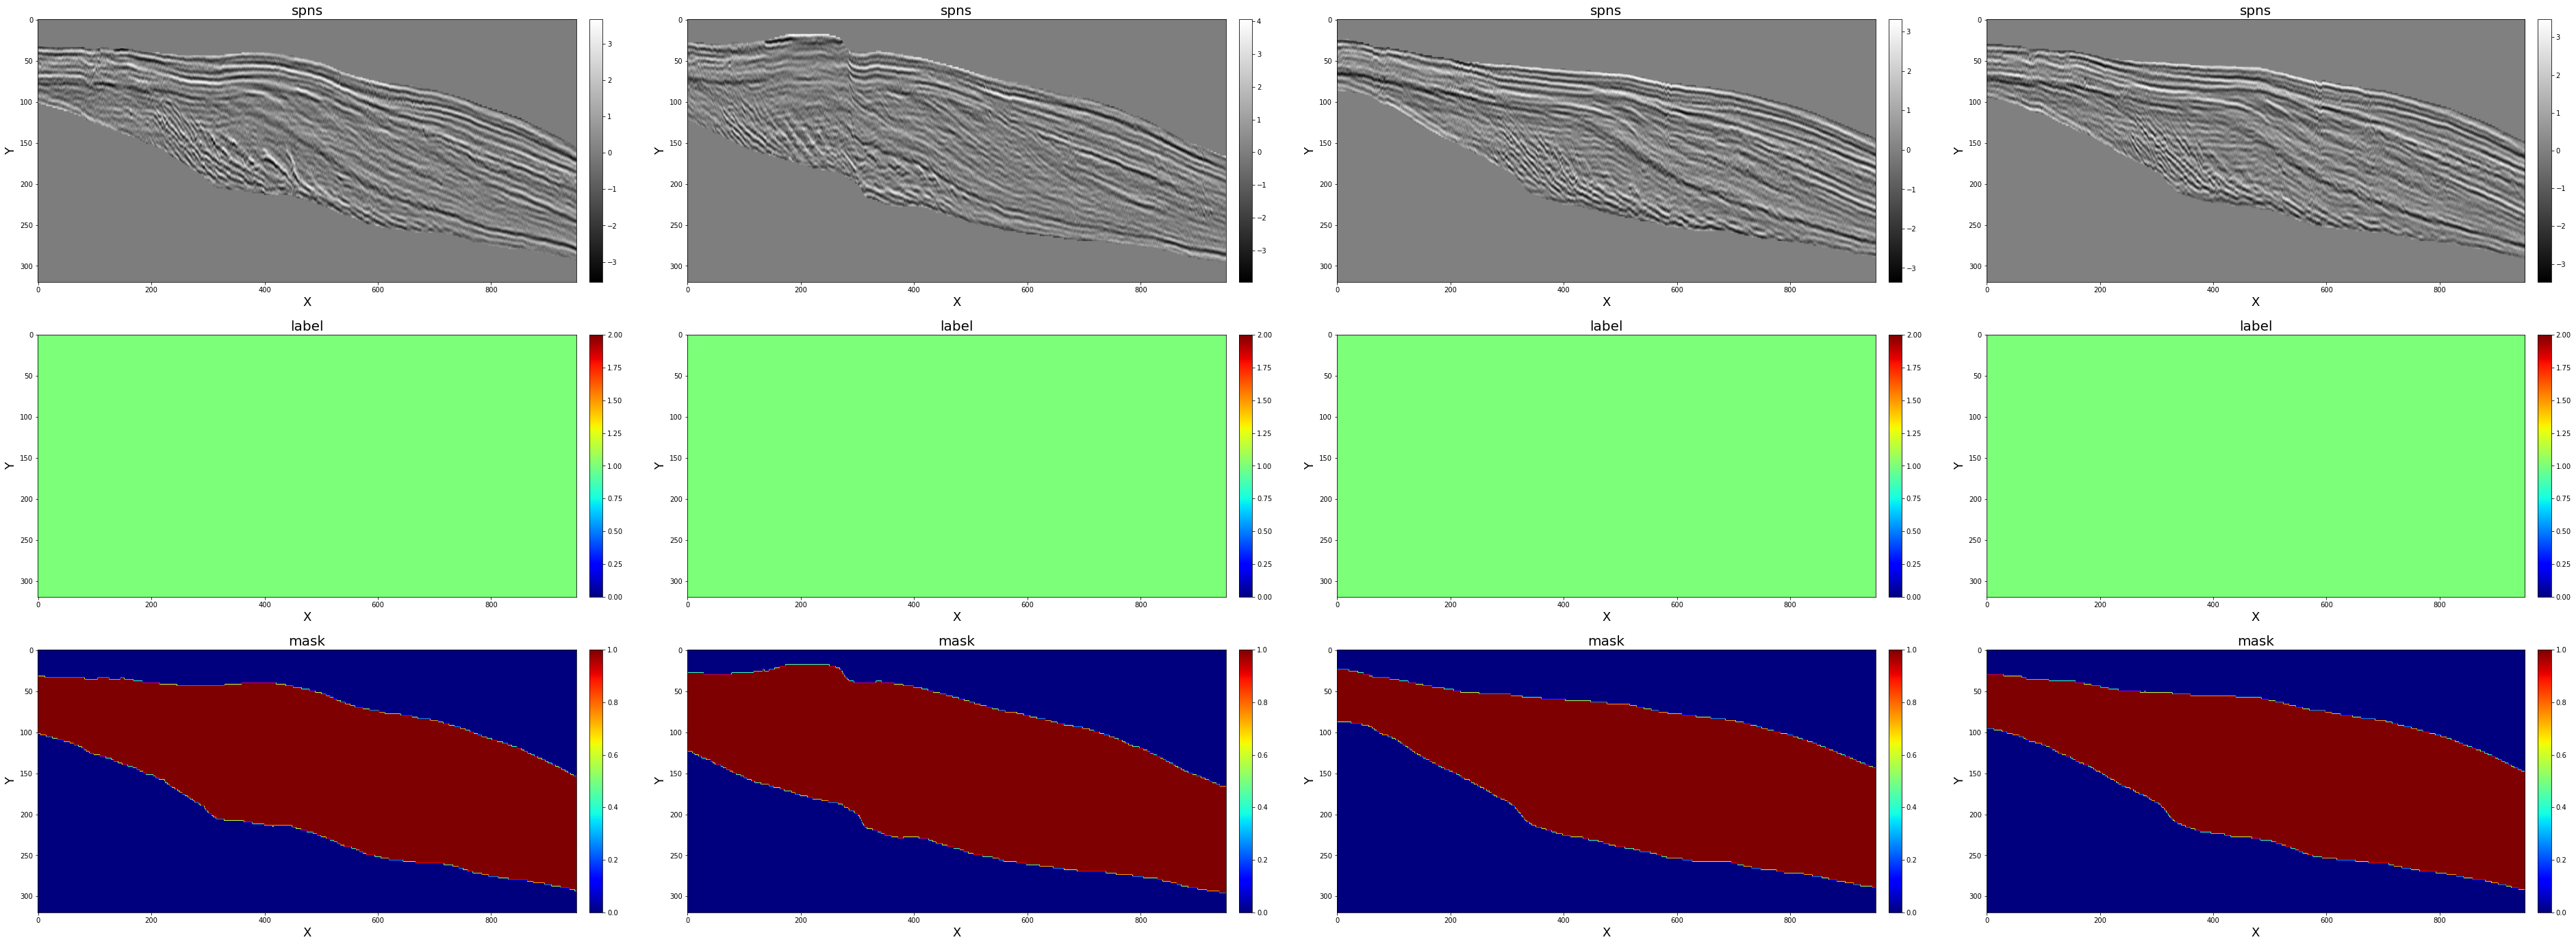

In [9]:
idxs = np.random.randint(0, len(test_data), size=4) 
batch_samples = [test_data[i] for i in idxs]
draw_attr_list = ["spns","label","mask"]
draw.draw_samples(batch_samples, draw_attr_list,save=False,cmap=["gray", "jet","jet"], save_file='samples.png')

In [10]:
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

def pred(model, test_data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)
    
    model.eval()
    pred_samples = []
    with torch.no_grad():
        for batch_idx, batch_samples in enumerate(test_loader):

#             data = batch_samples['sx']
            for i, input_attr in enumerate(input_attrs):
                tmp = batch_samples[input_attr]
                if i  == 0:
                    data = tmp
                else:
                    data = torch.cat((data, tmp), dim=1)
                    
            for j, filter4_attr in enumerate(filter4_attrs): # filter
                tmp_f4 = batch_samples[filter4_attr]
                if j  == 0:
                    filter4 = tmp_f4
                else:
                    filter4 = torch.cat((filter4, tmp_f4), dim=1)
                    
            for j, filter16_attr in enumerate(filter16_attrs): # filter
                tmp_f16 = batch_samples[filter16_attr]
                if j  == 0:
                    filter16 = tmp_f16
                else:
                    filter16 = torch.cat((filter16, tmp_f16), dim=1)
            
            mask = batch_samples["mask"]
#             print(f"batch_samples['sx']:{data.shape}")
            data = utils.mea_std_norm(data)
    
            data = data.unsqueeze(1)
            filter4 = filter4.unsqueeze(1)
            filter16 = filter16.unsqueeze(1)
            target = batch_samples[output_attrs[0]].long().squeeze(1)

            data, target = data.to(device), target.to(device)
            filter4,filter16 = filter4.to(device),filter16.to(device)
            data, target = Variable(data), Variable(target)
            filter4,filter16 = Variable(filter4),Variable(filter16)
            
            target_i = model(data,filter4,filter16)  
            
            if target_i.shape[1] > 1:
                target_j = F.softmax(target_i, dim=1)
                target_j = torch.argmax(target_j, dim=1, keepdim=True)
            else:
                target_j = torch.sigmoid(target_i[:,:1])
                target_j = utils.threshold_predictions(target_j, thr=0.6)
            
            target_prob = F.softmax(target_i, dim=1)
            target_prob0 = target_prob[:,0,:,:]
            target_prob1 = target_prob[:,1,:,:]
            target_prob0 = target_prob0.unsqueeze(1)
            target_prob1 = target_prob1.unsqueeze(1)
            target_prob0 = target_prob0.cpu().numpy().squeeze(0)
            target_prob1 = target_prob1.cpu().numpy().squeeze(0)
            
            target_j = target_j.cpu().numpy().squeeze(0)
            target = target.cpu().numpy().squeeze(0)
            data = data.cpu().numpy().squeeze(0)
            mask = mask.cpu().numpy().squeeze(0)
            
            batch_samples["pred"] = np.where(mask==0,np.nan,target_j)
            batch_samples["data"] = np.where(mask==0,np.nan,data)
            batch_samples["label"] = np.where(mask==0,np.nan,target)
            batch_samples["prob0"] =  np.where(mask==0,np.nan,target_prob0)
            batch_samples["prob1"] =  np.where(mask==0,np.nan,target_prob1)
            
            pred_samples.append(batch_samples)
    return pred_samples

pred_samples = pred(model, test_data)
print("done")

done


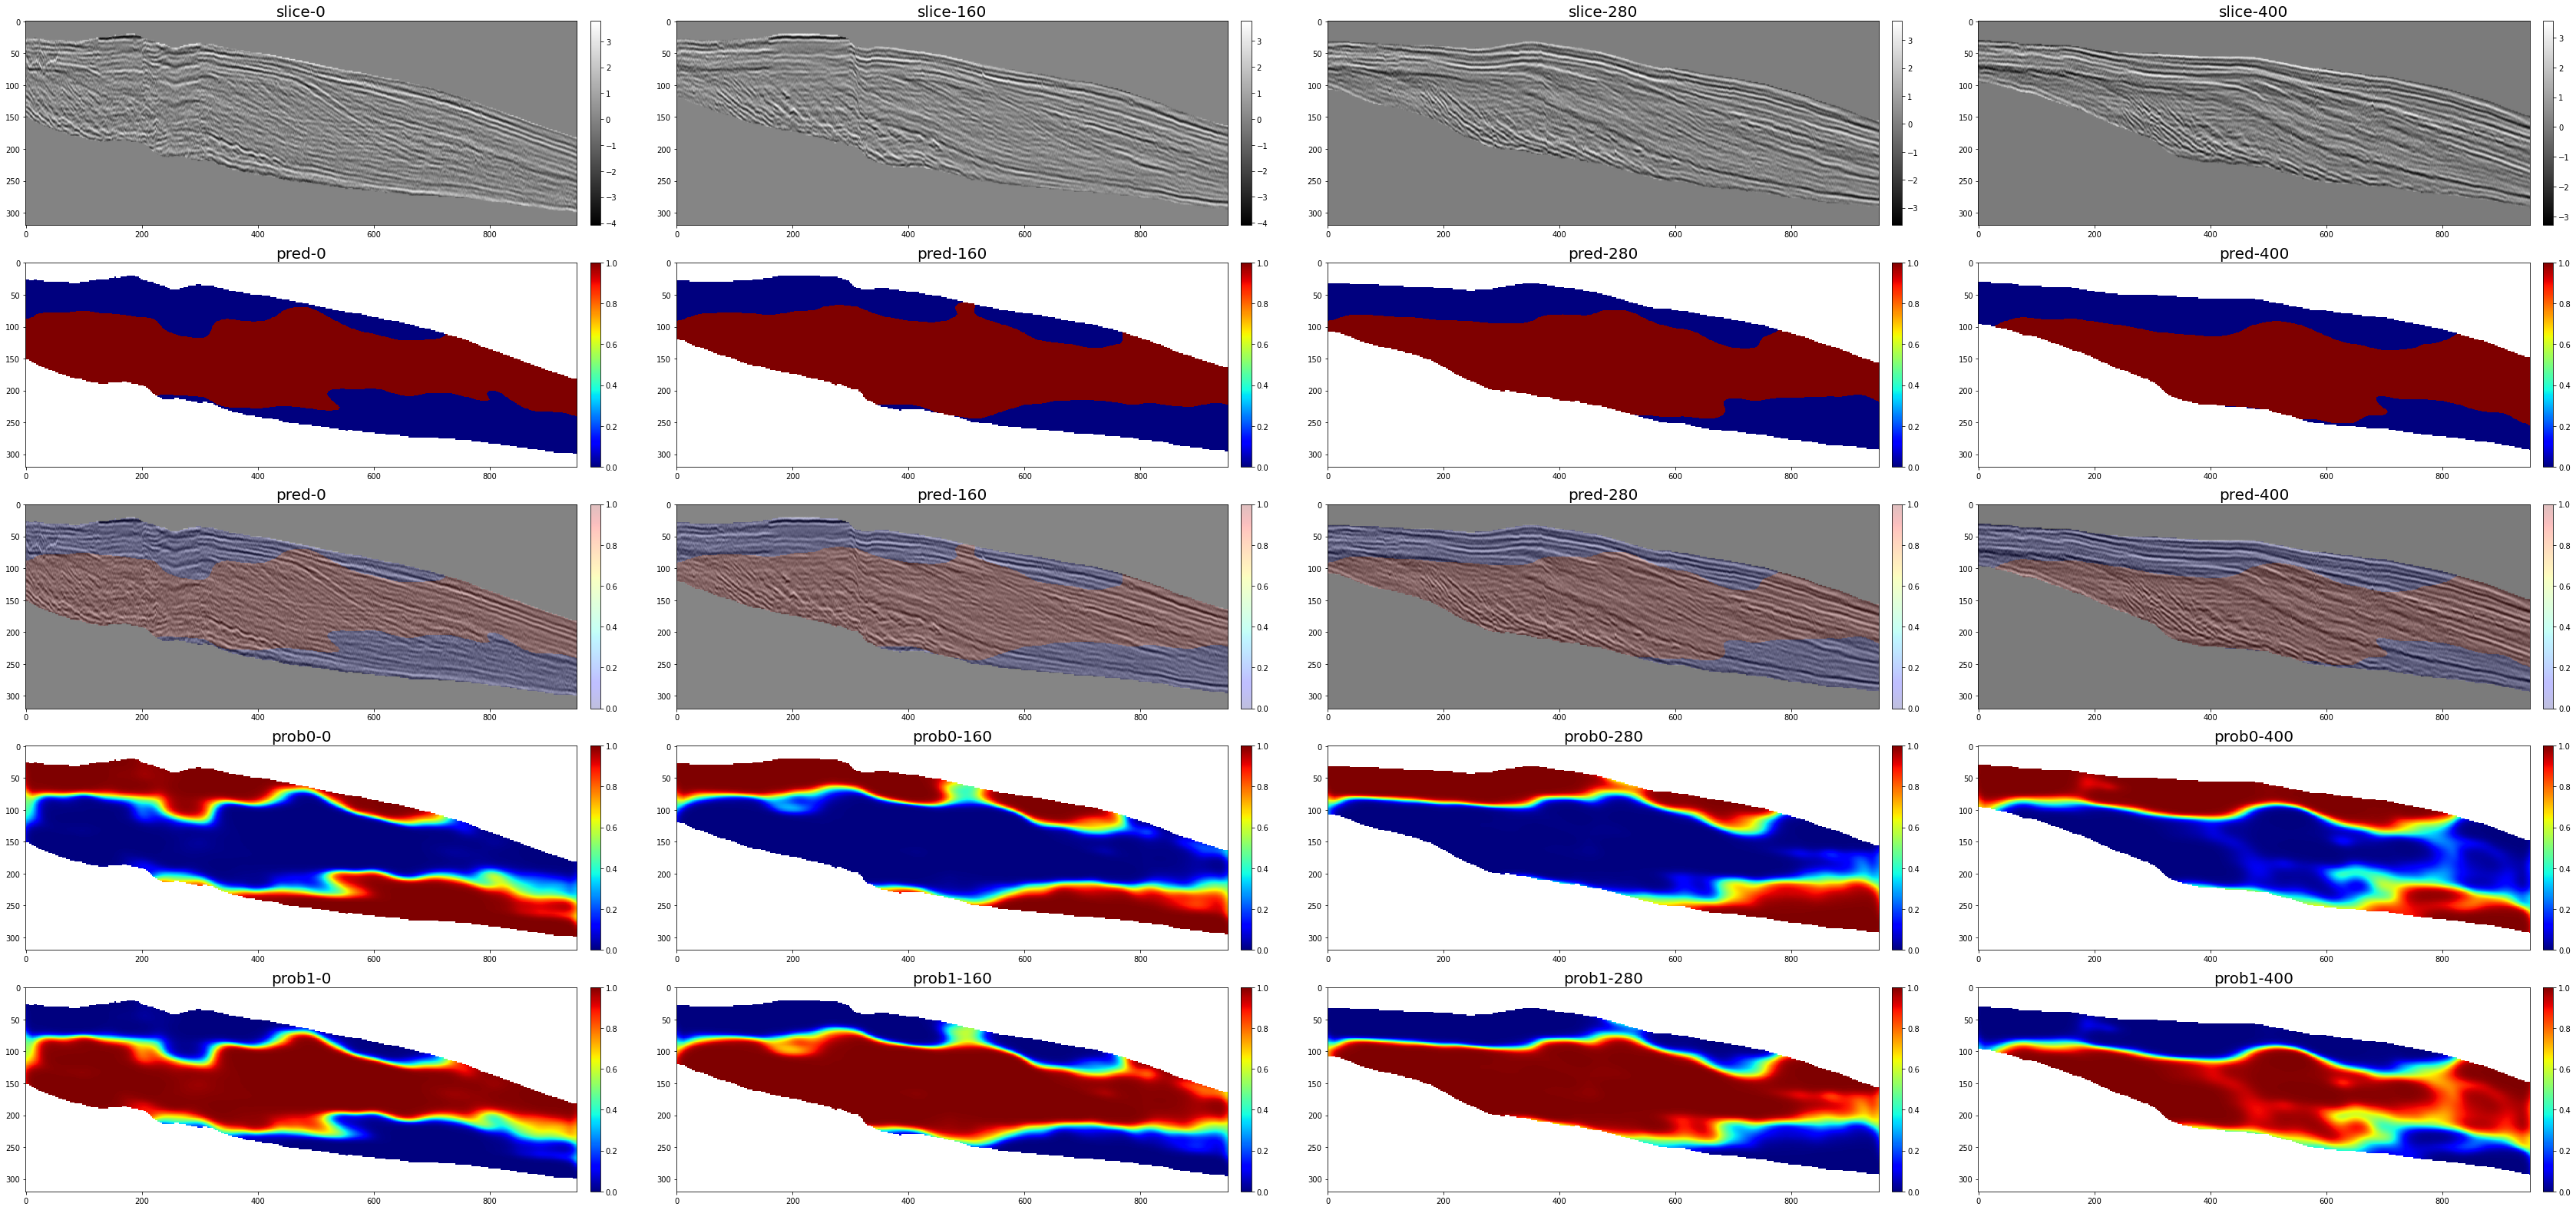

In [11]:
slices = [0,160,280,400]
plt.figure(figsize=(48,22))
k=0
for i in range(4):
    seis = pred_samples[int(slices[i])]["spns"].squeeze()    
    pred = pred_samples[int(slices[i])]["pred"].squeeze()
    pro0 = pred_samples[int(slices[i])]["prob0"].squeeze()
    pro1 = pred_samples[int(slices[i])]["prob1"].squeeze()
    
    plt.subplot(5,4,k+1)
    plt.imshow(seis,cmap="gray",aspect="auto",interpolation="bilinear")
    plt.title("slice-"+str(slices[i]),fontsize=20)
    plt.colorbar(pad=0.02)
    
    plt.subplot(5,4,k+5)
    plt.imshow(pred,cmap="jet",vmin=0,vmax=1,aspect="auto",interpolation="nearest")
    plt.title("pred-"+str(slices[i]),fontsize=20)
    plt.colorbar(pad=0.02)
    
    plt.subplot(5,4,k+9)
    plt.imshow(seis,cmap="gray",aspect="auto",interpolation="bilinear")
    plt.imshow(pred,cmap="jet",vmin=0,vmax=1,aspect="auto",interpolation="nearest",alpha=0.25)
    plt.title("pred-"+str(slices[i]),fontsize=20)
    plt.colorbar(pad=0.02)
    
    plt.subplot(5,4,k+13)
    plt.imshow(pro0,cmap="jet",vmin=0,vmax=1,aspect="auto",interpolation="nearest")
    plt.title("prob0-"+str(slices[i]),fontsize=20)
    plt.colorbar(pad=0.02)
    
    plt.subplot(5,4,k+17)
    plt.imshow(pro1,cmap="jet",vmin=0,vmax=1,aspect="auto",interpolation="nearest")
    plt.title("prob1-"+str(slices[i]),fontsize=20)
    plt.colorbar(pad=0.02)
    k+=1
plt.tight_layout()
# plt.savefig(datafloder_name+".png",bbox_inches='tight',dpi=300)